## Setup and Import Packages

In [ ]:
#!pip install geopandas

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas
import h5py
from shapely.geometry import Point

# New module named tensorflow will be used.
# Tensorflow is a module for machine learning, neural network, ...
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# for model reporting
from sklearn.metrics import classification_report

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/')

## Thin ice and open water height/elev correction

In [ ]:
### calculate z-score
from scipy.stats import zscore

def set_elev_correction(window_data_slice, input_data):
    
    df_label = window_data_slice.label.max()
    print(df_label)
    
    thick_ice_slice = window_data_slice[window_data_slice['label']==0]
    thin_ice_slice = window_data_slice[window_data_slice['label']==1]
    open_water_slice = window_data_slice[window_data_slice['label']==2]
    
    thick_ice_slice['z_score'] = zscore(thick_ice_slice['h_cor_mean'])
    thin_ice_slice['z_score'] = zscore(thin_ice_slice['h_cor_mean'])
    open_water_slice['z_score'] = zscore(open_water_slice['h_cor_mean'])    
    window_data_slice = thick_ice_slice.append(thin_ice_slice.append(open_water_slice)).sort_values(by=['x_atc'])   
    #print(window_data_slice)
    
    for df in range(len(window_data_slice)):
        idx = window_data_slice.index[df]
        input_data.loc[idx, 'z_score'] = window_data_slice.z_score.iloc[df]
    return

def get_next_window_idx2(index, radius, input_data):
    #print("getting next window index ")
    base_x = input_data.x_atc.iloc[index] 
    start_window_dist_x = base_x - radius
    end_window_dist_x = base_x + radius
    print(base_x, start_window_dist_x, end_window_dist_x)
    window_data_slice = input_data.loc[(input_data['x_atc'] > start_window_dist_x) & (input_data['x_atc'] < end_window_dist_x), ['x_atc', 'h_cor_mean', 'label']]
    #print(window_data_slice)
    
    set_elev_correction(window_data_slice, input_data)
    
    index_next = window_data_slice.index[-1]+1
    return index_next

def find_elev_correction(radius, input_data):
    index = 0
    count = 0
    print("data length ", len(input_data))
    while index < len(input_data):
        count += 1
        index = get_next_window_idx2(index, radius, input_data)
        print(index, count)
        #debug mode
        #break
    return


In [ ]:
###### 10m 5km ########
import glob, os
import time

dir_path = "ATL03_labeled_data/ow_labeled_by_is2trackline_10m_corrected/labeled_track/"
dest_path = "ATL03_labeled_data/ow_labeled_10m_z_score_corrected/"
filelist = sorted(glob.glob(dir_path + "ATL03_" + "*_labeled_10m.csv"))
missing_filelist = []
missing_data = 0
radius = 5000

for file in filelist:
    print(file)
    start = time.time()
    labeled_data = pd.read_csv(file, index_col=0)   
    #labeled_data = labeled_data[labeled_data['sea_surf_min_elev'].notna()]
    labeled_data = labeled_data[labeled_data.h_cor_mean <= 10]
    labeled_data = labeled_data[labeled_data['label'].notna()]
    labeled_data = labeled_data.reset_index(drop=True)
    
    print("find_elev_correction commented out for notebook storage issue")
    break
    find_elev_correction(radius, labeled_data)
    
    nan_count = labeled_data['z_score'].isna().sum()   
    if(nan_count > 0):
        #print("###############################################################################################",file)
        missing_filelist.append(file)
        missing_data += nan_count
    
    #ignore nan z_score data
    labeled_data = labeled_data[labeled_data['z_score'].notna()]
    
    #labeled_data.to_csv(file.replace(dir_path, dest_path).replace(".csv", "_z_score.csv"))
    del labeled_data
    #break
    
    end = time.time() - start
    print("Time per file is ",end)
    print("------------ File done ------------")

print("------------ Finish ------------")    
print("filelists ",len(filelist))
print("Missing filelists ",len(missing_filelist))
print("Missing data ",missing_data)
   
#labeled_data

In [ ]:
# missing_filelist

In [ ]:
# labeled_data = pd.read_csv('ATL03_labeled_data/shifted_labeled_10m_z_score_corrected/ATL03_20191103184432_05780510_gt1r_labeled_10m_z_score.csv', index_col=0)
# nan_count = labeled_data['z_score'].isna().sum()   
# print(nan_count)

## Sea Surface height using sliding window

In [ ]:
import sys

def set_sea_surface_ow(window_data_slice):
    
    #df[df['Capacity'].ne(0)].min()
    #label max cz 2 = water, 1 = thin ice, 0 = thick ice
    df_label = window_data_slice.pred_label.max()
    print(df_label)
    
    #everythin thick ice
    if df_label <= 1:
        min_elev = np.nan
        avg_elev = np.nan
        min_dist_low10 = pd.DataFrame()
        #count_nan += 1
    else:
        min_elev = window_data_slice.h_cor_mean[window_data_slice['pred_label'].eq(df_label)].min()
        print("Min elev = ", min_elev)
        avg_elev = window_data_slice.h_cor_mean[window_data_slice['pred_label'].eq(df_label)].mean()
        print("Avg elev = ", avg_elev)
    
        #min dist sea surface 10 lowest elev data sorted by x
        #handle label as well....
        min_dist_low10 = window_data_slice[window_data_slice['pred_label'].eq(df_label)].sort_values(by='h_cor_mean', ignore_index=False).iloc[:10].sort_values(by='x_atc', ignore_index=False)
        #print(min_dist_low10)
    
    for df in range(len(window_data_slice)):
        idx = window_data_slice.index[df]
        data_copy.loc[idx, 'sea_surf_min_elev'] = min_elev
        data_copy.loc[idx, 'sea_surf_avg_elev'] = avg_elev
        
        #min dist sea surface
        x = window_data_slice.x_atc.iloc[df]
        min_dist_elev = np.nan
        
        min_dist = sys.float_info.max
        min_dist_idx = -1
        ## make it efficient how the minimum is speard out----- binary search
        if not min_dist_low10.empty:

            for df2, row in min_dist_low10.iterrows():
                #print('index: ', i, 'col g:', row['g'])
                #print(df2)
                x2 = row['x_atc']#min_dist_low10.x[df2]
                diff = abs(x - x2)
                if(diff<min_dist):
                    min_dist = diff
                    min_dist_idx = df2
            #print("min dist idx", min_dist_idx) 
            #print("min dist diff", min_dist)
        
            min_dist_elev = min_dist_low10.h_cor_mean[min_dist_idx] #numpy array
            #print("Min Dist elev = ", min_dist_elev, " Min elev = ", min_elev)
            
        if(min_dist_elev<min_elev):
            print("Min Dist elev = ", min_dist_elev, " Min elev = ", min_elev)
        data_copy.loc[idx, 'sea_surf_min_dist'] = min_dist_elev
        
    return

def get_next_window_idx_ow(index, radius):
    #print("getting next window index ")
    base_x = data_copy.x_atc.iloc[index] 
    start_window_dist_x = base_x - radius
    end_window_dist_x = base_x + radius
    print(base_x, start_window_dist_x, end_window_dist_x)
    window_data_slice = data_copy.loc[(data_copy['x_atc'] > start_window_dist_x) & (data_copy['x_atc'] < end_window_dist_x), ['x_atc', 'h_cor_mean', 'pred_label']]
    print(window_data_slice)
    
    set_sea_surface_ow(window_data_slice)
    
    index_next = window_data_slice.index[-1]+1
    return index_next

def find_sea_surface_ow(radius):
    index = 0
    count = 0
    print("data length ", len(data_copy))
    while index < len(data_copy):
        count += 1
        index = get_next_window_idx_ow(index,radius)
        print(index, count)
        #debug mode
        #break
    return



In [ ]:
#labeled_data = pd.read_csv("ATL03_labeled_data/labeled_by_is2trackline/ATL03_20191123180255_08830510_T04CEV_gt2r_labeled.csv", index_col=0)
#data_copy = labeled_data.sort_values(by=['x_atc'])
#data_copy = data_copy.loc[:, ~data_copy.columns.str.contains('^Unnamed')]
##data['FID'] = range(1, len(data) + 1)
#data_copy = data_copy[data_copy.h_cor_mean <= 15]
#data_copy = data_copy[data_copy['label'].notna()]
#data_copy = data_copy.reset_index(drop=True)
#
##radius 5 km
#radius = 5000.0
#
#data_copy['sea_surf_min_elev'] = np.nan
#data_copy['sea_surf_avg_elev'] = np.nan
#data_copy['sea_surf_min_dist'] = np.nan
#print(radius)
#find_sea_surface(radius)
#
#nan_count = data_copy['sea_surf_min_elev'].isna().sum()
#print("min elev nan ",nan_count)
#nan_count = data_copy['sea_surf_avg_elev'].isna().sum()
#print("avg elev nan ",nan_count)
#nan_count = data_copy['sea_surf_min_dist'].isna().sum()
#print("min dist elev nan ",nan_count)
#
#print(data_copy['sea_surf_min_elev'].isnull().values.any())
#print(data_copy['sea_surf_avg_elev'].isnull().values.any())
#print(data_copy['sea_surf_min_dist'].isnull().values.any())
#
#### freeboard calculation
#data_copy['freeboard_min_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_min_elev']
#data_copy['freeboard_avg_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_avg_elev']
#data_copy['freeboard_min_dist_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_min_dist']
#
#data_copy.to_csv("ATL03_labeled_data/labeled_by_is2trackline/ATL03_20191123180255_08830510_T04CEV_gt2r_labeled.csv".replace(".csv", "_5km.csv"))

## All file freeboard calc and to csv

In [ ]:
import glob, os
import time


begin = time.time()

file = "LSTM_final_prediction_new_param_all_data_pred_cor_label.csv"
print(file)

labeled_data = pd.read_csv(file, index_col=0)
data_copy = labeled_data.sort_values(by=['x_atc'])
data_copy = data_copy.loc[:, ~data_copy.columns.str.contains('^Unnamed')]
#data['FID'] = range(1, len(data) + 1)
data_copy = data_copy[data_copy.h_cor_mean <= 10]
data_copy = data_copy[data_copy['pred_label'].notna()]
data_copy = data_copy.reset_index(drop=True)

#radius 5 km
radius = 5000.0

data_copy['sea_surf_min_elev'] = np.nan
data_copy['sea_surf_avg_elev'] = np.nan
data_copy['sea_surf_min_dist'] = np.nan
print(radius)

#break
#print("find_sea_surface commented out for notebook storage issue")
find_sea_surface_ow(radius)


nan_count = data_copy['sea_surf_min_elev'].isna().sum()
print("min elev nan ",nan_count)
nan_count = data_copy['sea_surf_avg_elev'].isna().sum()
print("avg elev nan ",nan_count)
nan_count = data_copy['sea_surf_min_dist'].isna().sum()
print("min dist elev nan ",nan_count)

print(data_copy['sea_surf_min_elev'].isnull().values.any())
print(data_copy['sea_surf_avg_elev'].isnull().values.any())
print(data_copy['sea_surf_min_dist'].isnull().values.any())

### freeboard calculation
data_copy['freeboard_min_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_min_elev']
data_copy['freeboard_avg_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_avg_elev']
data_copy['freeboard_min_dist_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_min_dist']

data_copy.to_csv("LSTM_new_param_all_data_pred_cor_label_5km.csv")
del labeled_data, data_copy


end = time.time() - begin
print("Total time needed ",end)
print("------------ Finish ------------")    


# interpolate sea surface

In [ ]:
import glob, os
import time

file = "LSTM_new_param_all_data_pred_cor_label_5km.csv"

print(file)
begin = time.time()
labeled_data = pd.read_csv(file, index_col=0)
data_copy = labeled_data.sort_values(by=['x_atc'])
data_copy = data_copy.loc[:, ~data_copy.columns.str.contains('^Unnamed')]
#data['FID'] = range(1, len(data) + 1)
data_copy = data_copy[data_copy.h_cor_mean <= 10]
data_copy = data_copy[data_copy['pred_label'].notna()]
data_copy = data_copy.reset_index(drop=True)


nan_count = data_copy['sea_surf_min_elev'].isna().sum()
print("min elev nan ",nan_count)
nan_count = data_copy['sea_surf_avg_elev'].isna().sum()
print("avg elev nan ",nan_count)
nan_count = data_copy['sea_surf_min_dist'].isna().sum()
print("min dist elev nan ",nan_count)

print(data_copy['sea_surf_min_elev'].isnull().values.any())
print(data_copy['sea_surf_avg_elev'].isnull().values.any())
print(data_copy['sea_surf_min_dist'].isnull().values.any())

#break
#interpolation
data_copy['sea_surf_min_elev'] = data_copy['sea_surf_min_elev'].interpolate(method='linear', limit_direction='both', axis=0)
data_copy['sea_surf_avg_elev'] = data_copy['sea_surf_avg_elev'].interpolate(method='linear', limit_direction='both', axis=0)
data_copy['sea_surf_min_dist'] = data_copy['sea_surf_min_dist'].interpolate(method='linear', limit_direction='both', axis=0)


### freeboard calculation
data_copy['freeboard_min_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_min_elev']
data_copy['freeboard_avg_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_avg_elev']
data_copy['freeboard_min_dist_elev'] = data_copy['h_cor_mean'] - data_copy['sea_surf_min_dist']

data_copy.to_csv("LSTM_new_param_all_data_pred_cor_label_5km.csv")
del labeled_data, data_copy

end = time.time() - begin
print("Total time needed ",end)
print("------------ Finish ------------")    




## Sea surface(h_ref) from ATL07, duplicate removed and linear interpolation

In [ ]:
#

import glob, os
import time

src_dir_path = "ATL03_labeled_data/ow_labeled_10m_5km_corrected/"
dest_dir_path = "ATL03_labeled_data/ow_labeled_10m_corrected_atl07_sea_surface/"
filelist = sorted(glob.glob(src_dir_path + "ATL03_" + "*_labeled_10m_z_score_5km.csv"))

dir07_path = "csv_Iqrah/"
#filelist1 = sorted(glob.glob(dir_path1 + "ATL03_" + "*_dr.csv"))
#filelist07 = sorted(glob.glob(dir07_path + "ATL07-" + "*.csv"))

#display(filelist)
#display(filelist07)

begin = time.time()

for file in filelist:
    print(file)
    start = time.time()
    data_copy = pd.read_csv(file, index_col=0)
    beam03 = file[-32:-28]
    date = file[-56:-48]    
    #duplicated = labeled_data[labeled_data[['x_atc', 'label']].duplicated(keep=False)]
    dup_removed = data_copy.drop_duplicates(subset=['x_atc','label'])
    dup_removed = dup_removed.sort_values(by=['x_atc'])
    dup_removed = dup_removed.reset_index(drop=True)
    #display(dup_removed)
    
    atl07_file = glob.glob(dir07_path + "ATL07-02_" + date + "*.csv")
    if not atl07_file:
        continue
    print(atl07_file[0])
    atl07_data = pd.read_csv(atl07_file[0], index_col=0)
    atl07_data = atl07_data[atl07_data.beam == beam03]
    atl07_data = atl07_data.sort_values(by=['x'])
    atl07_data = atl07_data.reset_index(drop=True)
    #display(atl07_data)
    
    merged_data = pd.concat([atl07_data[['lon','h_ref','height']],dup_removed[['lon']]]).sort_values(by=['lon'])
    merged_data['h_ref'] = merged_data['h_ref'].interpolate(method='linear', limit_direction='both', axis=0)
    merged_data['height'] = merged_data['height'].interpolate(method='linear', limit_direction='both', axis=0)
    #display(merged_data)
    
    merged_data = merged_data.merge(dup_removed, on=['lon']).sort_values(by=['x_atc'])
    merged_data = merged_data.drop_duplicates(subset=['lon','h_ref','height'])
    merged_data = merged_data.reset_index(drop=True)
    merged_data['height_diff_03_07'] = merged_data['h_cor_mean'] - merged_data['height']
    idx_st = int(merged_data.shape[0]/4)
    mean_h_diff = merged_data['height_diff_03_07'].iloc[[idx_st,idx_st*2]].mean(axis=0)
    #mean_h_diff2 = merged_data['height_diff_03_07'].iloc[[74905, 112357]].mean(axis=0)
    #mean_h_diff = (mean_h_diff1+mean_h_diff2)/2
    print("mean_h_diff is : ", mean_h_diff)
    merged_data['h_ref'] = merged_data['h_ref'] + mean_h_diff
    merged_data = merged_data[(merged_data['h_cor_mean'] > merged_data['h_ref'])]
    merged_data['h_ref_freeboard_h_mean'] = merged_data['h_cor_mean'] - merged_data['h_ref'] 
    merged_data['h_ref_freeboard_h_med'] = merged_data['h_cor_med'] - merged_data['h_ref'] 
    
    #shp1 = merged_data[merged_data[['lon','h_ref']].duplicated()].shape
    #shp2 = data_copy[data_copy[['x_atc']].duplicated()].shape
    #if(shp1 != shp2):
        #print(shp1)
        #print(shp2)
    display(merged_data)
    
    #nan_count = dup_removed['sea_surf_min_elev'].isna().sum()
    #print(nan_count)
    #nan_count = merged_data['sea_surf_min_elev'].isna().sum()
    #print(nan_count)

    # re-extract the data
    thick_ice = merged_data[(merged_data.label == 0)]
    thin_ice = merged_data[(merged_data.label == 1)]
    water = merged_data[(merged_data.label == 2)]
    # re-extract the data
    thick_ice2 = atl07_data[(atl07_data.label == 2)]
    thin_ice2 = atl07_data[(atl07_data.label == 1)]
    water2 = atl07_data[(atl07_data.label == 0)]
    
    #plt.figure(figsize = (12,4), dpi=300)
    #field = 'height'
    #plt.scatter(merged_data.lat, merged_data[field], s = 2) 
    #field = 'h_cor_mean'
    #plt.scatter(merged_data.lat, merged_data[field], s = 2)
    #field = 'height_diff_03_07'
    #plt.scatter(merged_data.lat, merged_data[field], s = 2)
    #plt.grid(linestyle = ':', linewidth = 0.5)
    #plt.xlabel('along track lat (degree)')
    #plt.ylabel('elevation (m)')
    #plt.legend(['height', 'h_cor_mean', 'height diff 03 to 07'])
    #plt.show()
    
    #plt.figure(figsize = (12,4), dpi=300)
    #field = 'height'
    #plt.scatter(atl07_data.lon, atl07_data[field], s = 2, c = 'C0')
    #field = 'h_cor_mean'
    #plt.scatter(merged_data.lon, merged_data[field], s = 2, c = 'C1')
    #plt.grid(linestyle = ':', linewidth = 0.5)
    #plt.xlabel('along track long (degree)')
    #plt.ylabel('elevation (m)')
    #plt.legend([' atl07 nasa', ' 2m atl03 ours'])
    #plt.show()
    #plt.figure(figsize = (12,4), dpi=300)
    #field = 'h_cor_mean'
    #plt.scatter(merged_data.lon, merged_data[field], s = 2, c = 'C1')
    #field = 'height'
    #plt.scatter(atl07_data.lon, atl07_data[field], s = 2, c = 'C0')
    #plt.grid(linestyle = ':', linewidth = 0.5)
    #plt.xlabel('along track long (degree)')
    #plt.ylabel('elevation (m)')
    #plt.legend([' 2m atl03 ours',' atl07 nasa'])
    #plt.show()
    
    plt.figure(figsize = (12,4), dpi=300)
    field = 'height'
    plt.scatter(atl07_data.lat, atl07_data[field], s = 2, c = 'C0')
    field = 'h_cor_mean'
    plt.scatter(merged_data.lat, merged_data[field], s = 2, c = 'C1')
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track lat (degree)')
    plt.ylabel('elevation (m)')
    plt.legend([' atl07 nasa', ' 2m atl03 ours'])
    plt.show()
    plt.figure(figsize = (12,4), dpi=300)
    field = 'h_cor_mean'
    plt.scatter(merged_data.lat, merged_data[field], s = 2, c = 'C1')
    field = 'height'
    plt.scatter(atl07_data.lat, atl07_data[field], s = 2, c = 'C0')
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track lat (degree)')
    plt.ylabel('elevation (m)')
    plt.legend([' 2m atl03 ours',' atl07 nasa'])
    plt.show()
    
    #plt.figure(figsize = (12,4), dpi=300)
    #field = 'freeboard'
    #plt.scatter(thick_ice2.lon, thick_ice2[field], s = 2, c='C0')
    #field = 'freeboard_10'
    #plt.scatter(thick_ice2.lon, thick_ice2[field], s = 2, c='C1')
    #field = 'h_ref_freeboard_h_mean'
    #plt.scatter(thick_ice.lon, thick_ice[field], s = 2, c='C2')
    #plt.grid(linestyle = ':', linewidth = 0.5)
    #plt.xlabel('along track long (degree)')
    #plt.ylabel('elevation (m)')
    #plt.legend(['thick ice freeboard atl07 nasa', 'thick ice freeboard atl10 nasa', 'thick ice freeboard 2m atl03'])
    #plt.show()
    #plt.figure(figsize = (12,4), dpi=300)
    #field = 'h_ref_freeboard_h_mean'
    #plt.scatter(thick_ice.lon, thick_ice[field], s = 2, c='C2')
    #field = 'freeboard'
    #plt.scatter(thick_ice2.lon, thick_ice2[field], s = 2, c='C0')
    #field = 'freeboard_10'
    #plt.scatter(thick_ice2.lon, thick_ice2[field], s = 2, c='C1')
    #plt.grid(linestyle = ':', linewidth = 0.5)
    #plt.xlabel('along track long (degree)')
    #plt.ylabel('elevation (m)')
    #plt.legend(['thick ice freeboard 2m atl03', 'thick ice freeboard atl07 nasa', 'thick ice freeboard atl10 nasa'])
    #plt.show()
    
    
    plt.figure(figsize = (12,4), dpi=300)
    field = 'freeboard'
    plt.scatter(thick_ice2.lat, thick_ice2[field], s = 2, c='C1')
    field = 'freeboard_10'
    plt.scatter(thick_ice2.lat, thick_ice2[field], s = 2, c='C2')
    field = 'h_ref_freeboard_h_mean'
    plt.scatter(thick_ice.lat, thick_ice[field], s = 2, c='C0')
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track lat (degree)')
    plt.ylabel('elevation (m)')
    plt.legend(['thick ice freeboard atl07 nasa', 'thick ice freeboard atl10 nasa', 'thick ice freeboard 2m atl03'])
    plt.show()
    plt.figure(figsize = (12,4), dpi=300)
    field = 'h_ref_freeboard_h_mean'
    plt.scatter(thick_ice.lat, thick_ice[field], s = 2, c='C0')
    field = 'freeboard'
    plt.scatter(thick_ice2.lat, thick_ice2[field], s = 2, c='C1')
    field = 'freeboard_10'
    plt.scatter(thick_ice2.lat, thick_ice2[field], s = 2, c='C2')
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track lat (degree)')
    plt.ylabel('elevation (m)')
    plt.legend(['thick ice freeboard 2m atl03', 'thick ice freeboard atl07 nasa', 'thick ice freeboard atl10 nasa'])
    plt.show()
    
    
    plt.figure(figsize = (12,4), dpi=300)
    field = 'h_ref_freeboard_h_mean'
    plt.scatter(thick_ice.lat, thick_ice[field], s = 2, c='C0')
    #field = 'freeboard'
    #plt.scatter(thick_ice2.lat, thick_ice2[field], s = 2, c='C1')
    field = 'freeboard_10'
    plt.scatter(thick_ice2.lat, thick_ice2[field], s = 2, c='C2')
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track lat (degree)')
    plt.ylabel('elevation (m)')
    plt.legend(['thick ice freeboard 2m atl03','thick ice freeboard atl10 nasa'])
    plt.show()
    
    plt.figure(figsize = (12,4), dpi=300)
    field = 'h_ref'
    plt.scatter(atl07_data.lon, atl07_data[field], s = 2)
    plt.scatter(merged_data.lon, merged_data[field], s = 2)
    field = 'sea_surf_min_elev'
    plt.scatter(merged_data.lon, merged_data[field], s = 2)
    field = 'h_ref_10'
    plt.scatter(atl07_data.lon, atl07_data[field], s = 2)
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track long (degree)')
    plt.ylabel('elevation (m)')
    plt.legend(['SS atl07 nasa', 'merged ATL03 ATL07', 'sea_surf_min_elev', 'SS atl10 nasa'])
    plt.show()
    

    
    plt.figure(figsize = (12,4), dpi=300)
    field = 'h_ref'
    plt.scatter(atl07_data.lon, atl07_data[field], s = 2)
    plt.scatter(merged_data.lon, merged_data[field]-0.65, s = 2)
    field = 'h_ref_10'
    plt.scatter(atl07_data.lon, atl07_data[field], s = 2)
    plt.grid(linestyle = ':', linewidth = 0.5)
    plt.xlabel('along track long (degree)')
    plt.ylabel('elevation (m)')
    plt.legend(['SS atl07 nasa', 'merged ATL03 ATL07', 'SS atl10 nasa'])
    plt.show()
    

    merged_data.to_csv(file.replace(src_dir_path, dest_dir_path).replace(".csv", "_atl07_sea_surf_dr.csv"))
    del dup_removed, data_copy, merged_data
    
    end = time.time() - start
    print("Time per file is ",end)
    print("------------ File done ------------")
    
    #break

end = time.time() - begin
print("Total time needed ",end)
print("------------ Finish ------------")    


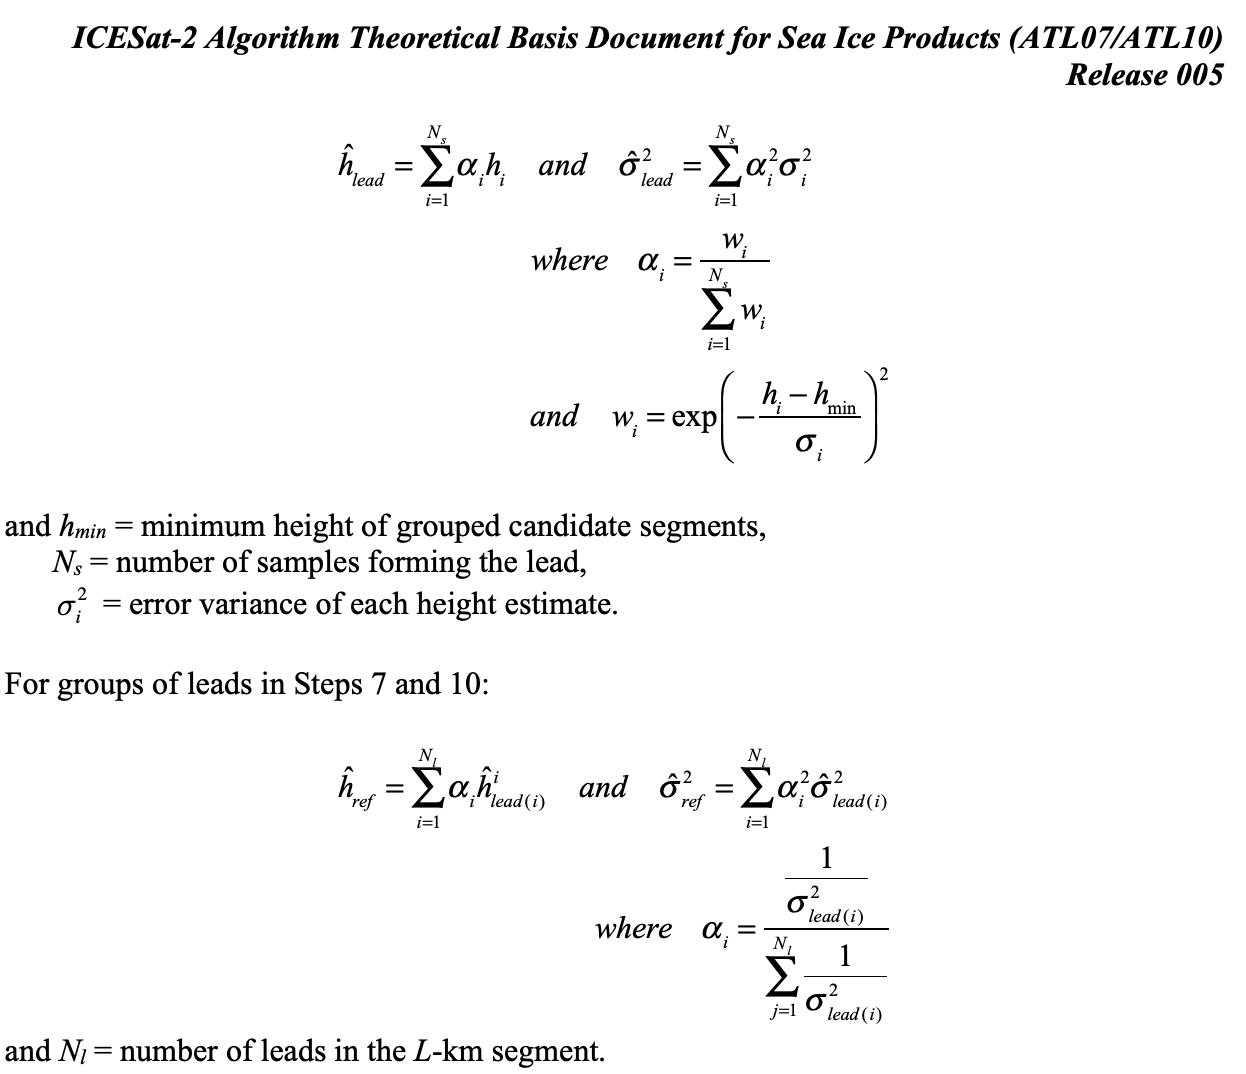## New Sea Surface Algorithm
### Over duplicate removed, selected heights only over the sea surface and atl07 sea surface files for comparison
<div>
<img src="attachment:atbd_sea_surface_eqn.png" width="500"/>
</div>

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy import interpolate

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    if len(A) == 1:
        return A
    else:
        ind_valid = np.where(A > -1000)[0]
        if len(ind_valid) > 0:
            if 0 not in ind_valid:
                A[0] = A[ind_valid[0]]
            if len(A)-1 not in ind_valid:
                A[-1] = A[ind_valid[-1]]
            inds = np.arange(A.shape[0])
            good = np.where(A > -1000)
            f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
            B = np.where(np.isfinite(A),A,f(inds))
            return B
        else:
            return A

def smooth_line(data, w = 2):
    # Smooth the surface with the defined window size
    output = np.zeros(len(data))
    for n in range(0, len(data)):
        output[n] = np.nanmean(data[max(0, n-w):min(len(data), n+w+1)])
    return output

def match_freeboard(test07, test10, th = 0.04):
    # L: segment length (default: 10 km  = 10,000 m)
    idxs = np.unique(test10['refsur_ndx'])
    
    h_ref = np.zeros(len(idxs))*np.nan
    s_ref = np.zeros(len(idxs))*np.nan
    
    for i in range(0, len(idxs)): # np.unique(test10['refsur_ndx']):
        idx = idxs[i]
        L_idx = np.where(test10['refsur_ndx'] == idx)[0]
        pdata = test07.loc[L_idx, :].reset_index(drop = True)        
        
        hlead = []
        slead = []
        
        if len(pdata) > 0:           
            
            #no need
            #q = np.quantile(pdata["height"].values, 0.1)
            lead_idx = np.where((pdata['label'] < 1) & (pdata['h_norm'] <= th))[0]  # & (pdata['height'] <= q)
            #no need
            #slope = np.polyfit(pdata["x"].values, pdata["height"].values, 1)[0]
            # slope should be < 20 cm / 10 km (ref. ATL07/ATL10 document)
            
            #if len(lead_idx) == 0:
            #    L_idx = np.where((test10['refsur_ndx']>=idx-1)&((test10['refsur_ndx']<=idx+1)))[0]
            #    pdata = test07.loc[L_idx, :].reset_index(drop = True)                 
            #    lead_idx = np.where((pdata['label'] < 1) & (pdata['h_norm'] <= th))[0]
        
            if len(lead_idx) == 0:
                lead_idx = np.where((pdata['label'] < 2) & (pdata['h_norm'] <= 0.01))[0]
            
            if (len(lead_idx) > 0):

                ## 2. surrounding height filter
                lead_id = 0 # iceberg id

                # Find the consecutive indices
                #1,2,3...8,9,10
                id_start = [0]
                id_end = []

                for n in range(0, len(lead_idx)-1):
                    if abs(pdata['seg_id'][lead_idx[n+1]] - pdata['seg_id'][lead_idx[n]]) != 1:
                        id_start.append(n+1)
                        id_end.append(n)
                id_end.append(len(lead_idx)-1)  
                

                for n in range(0, len(id_start)):

                    id1 = id_start[n] # id of the left lead point
                    id2 = id_end[n] # id of the right lead point

                    idx = lead_idx[id1:id2+1]

                    hi = pdata.loc[idx, "height"].values
                    hmin = hi.min()
                    si = pdata.loc[idx, "error"].values #**0.5           
                    wi = np.exp(-(hi-hmin)/si)**2
                    ai = wi / np.sum(wi)

                    hlead.append(np.sum(ai*hi))
                    slead.append(np.sum((ai**2)*(si**2)))

                    lead_id += 1

                hlead = np.array(hlead)
                slead = np.array(slead)
                alead = (1/slead)/np.sum(1/slead)

                h_ref[i] = np.sum(hlead*alead)
                s_ref[i] = np.sum((alead**2)*slead)
    
    h_ref = fill_nan(h_ref)
    h_ref = smooth_line(h_ref, w = 1)
    
    for i in range(0, len(idxs)): # np.unique(test10['refsur_ndx']):
        idx = idxs[i]
        L_idx = np.where(test10['refsur_ndx'] == idx)[0]
        test07.loc[L_idx, "h_ref"] = h_ref[i]
        test07.loc[L_idx, "s_ref"] = s_ref[i]
    
    freeboard = test07["height"].values - test07["h_ref"].values
    freeboard[freeboard < 0] = 0
    test07["freeboard"] = freeboard
    
    return test07

In [ ]:
import sys
import math

def set_new_sea_surface_eqn_ow(window_data_slice):
    
    #df[df['Capacity'].ne(0)].min()
    #label max cz 2 = water, 1 = thin ice, 0 = thick ice
    df_label = window_data_slice.pred_label.max()
    print("DF Label is ",df_label)
    
    #everythin thick ice
    if df_label <= 1:
        min_elev = np.nan
        h_ref = np.nan
        s_ref = np.nan
        #count_nan += 1
    else:
        min_elev = window_data_slice.h_cor_mean[window_data_slice['pred_label'].eq(df_label)].min()
        #print("Min elev using label = ", min_elev)
        # N_s = number of samples forming the lead,
        N_s = window_data_slice.h_cor_mean[window_data_slice['pred_label'].eq(df_label)].count()
        print("N_s = ", N_s)
    
    #find no. of groups of leads with start and end idx
    #why normalization???
    #youngs -> water = 0, thin ice = 1, thick ice = 2
    
    #only water
    lead_idx = window_data_slice[window_data_slice['pred_label'] > 1].index
    #lead_idx = np.where((window_data_slice['label'] > 1))[0]# & (window_data_slice['h_norm'] <= th))[0]     
    #water and thin ice
    if len(lead_idx) == 0:
        lead_idx = window_data_slice[window_data_slice['pred_label'] > 0].index
        #lead_idx = np.where((window_data_slice['label'] > 0))[0]# & (pdata['h_norm'] <= 0.01))[0]
    print("lead idx --> ", lead_idx)
    
    if (len(lead_idx) > 0 ):
        
        ## 2. surrounding height filter
        lead_id = 0 # iceberg id

        # Find the consecutive indices
        #1,2,3...8,9,10
        id_start = [lead_idx[0]]
        id_end = []
        
        #lead_idx -> [68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 
        #84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
        
        for n in range(0, len(lead_idx)-1):
            if abs(lead_idx[n+1] - lead_idx[n]) != 1:
                id_start.append(lead_idx[n+1])
                id_end.append(lead_idx[n])
        id_end.append(lead_idx[len(lead_idx)-1])
        
        print(id_start,id_end,len(id_start))

        hlead = []
        slead = []
        
        for n in range(0, len(id_start)):

            id1 = id_start[n] # id of the left lead point
            id2 = id_end[n] # id of the right lead point
            print("id1 and id2 ",id1,id2)
            #hi = window_data_slice.h_cor_mean.iloc[id1:id2+1]
            hi = window_data_slice.loc[id1:id2+1, "h_cor_mean"].values
            #print("hi ",hi)
            hmin = hi.min()#round(hi.min(), 8)
            #print("hmin",hmin)
            #si = window_data_slice.height_sd.iloc[id1:id2+1] #**0.5
            si = window_data_slice.loc[id1:id2+1, "height_sd"].values
            #print("si ",si)
            #print("hi-hmin",hi-hmin)
            #print("hi-hmin/si",(hi-hmin)/si)
            #print("-(hi-hmin)/si",-(hi-hmin)/si)
            wi = np.exp(-(hi-hmin)/si)**2
            #print("wi ",wi)
            #print("np.sum(wi)",np.sum(wi))
            ai = wi / np.sum(wi)
            #print("ai ",ai)
            print("partial hlead ",np.sum(ai*hi))
            print("partial slead ",np.sum((ai**2)*(si**2)))
            hlead.append(np.sum(ai*hi))
            slead.append(np.sum((ai**2)*(si**2)))

            lead_id += 1
        
        print("lead_id ",lead_id)
        
        print("hlead ", hlead)
        print("slead ", slead)
        
        hlead = np.array(hlead)
        slead = np.array(slead)
        
        print("hlead ", hlead)
        print("slead ", slead)
        
        alead = (1/slead)/np.sum(1/slead)
        
        print("alead ", alead)
        
        h_ref = np.sum(hlead*alead)
        s_ref = np.sum((alead**2)*slead)
        print("h_ref",h_ref)
        print("s_ref",s_ref)
        
    for df in range(len(window_data_slice)):
        idx = window_data_slice.index[df]
        data_copy.loc[idx, 'new_h_ref'] = h_ref
        data_copy.loc[idx, 'new_s_ref'] = s_ref
    
    print("Done")
    
    return

def get_next_window_index_ow(index, radius):
    #print("getting next window index ")
    base_x = data_copy.x_atc.iloc[index] 
    start_window_dist_x = base_x - radius
    end_window_dist_x = base_x + radius
    print(base_x, start_window_dist_x, end_window_dist_x)
    window_data_slice = data_copy.loc[(data_copy['x_atc'] > start_window_dist_x) & (data_copy['x_atc'] < end_window_dist_x), ['x_atc', 'h_cor_mean', 'height_sd', 'pred_label']]
    display(window_data_slice)#.head(50))
    
    if len(window_data_slice) > 0:
        set_new_sea_surface_eqn_ow(window_data_slice)
    
    index_next = window_data_slice.index[-1]+1
    return index_next

def find_new_sea_surface_ow(radius):
    index = 0
    count = 0
    print("data length ", len(data_copy))
    while index < len(data_copy):
        count += 1
        index = get_next_window_index_ow(index,radius)
        print("next window index and count(window number) ",index, count)
        #debug mode
        #break
    return


In [ ]:
import glob, os
import time


begin = time.time()
file = "LSTM_new_param_all_data_pred_cor_label_5km.csv"
data_copy = pd.read_csv(file, index_col=0)
print(data_copy.keys())
#radius 5 km
radius = 5000.0
print(radius)
#break
find_new_sea_surface_ow(radius)

nan_count = data_copy['new_h_ref'].isna().sum()
print("new_h_ref elev nan ",nan_count)

print(data_copy['new_h_ref'].isnull().values.any())


#interpolation
data_copy['new_h_ref'] = data_copy['new_h_ref'].interpolate(method='linear', limit_direction='both', axis=0)

### freeboard calculation
data_copy['freeboard_new_h_ref'] = data_copy['h_cor_mean'] - data_copy['new_h_ref']

display(data_copy)
print(data_copy.columns.tolist())

data_copy.to_csv("LSTM_new_param_all_data_pred_cor_label_5km_new_sea_surf.csv")
del data_copy


end = time.time() - begin
print("Total time needed ",end)
print("------------ Finish ------------")    


In [ ]:
import glob, os
import time

begin = time.time()

file = "LSTM_new_param_all_data_pred_cor_label_5km_new_sea_surf.csv"
print(file)
data_copy = pd.read_csv(file, index_col=0)
day = 4
beam = "gt2r"
lon1 = -170.5 #-171.0
lon2 = -170.0
#track_field = #'track'#'track_x'
track_field = 'track_x'
data_copy = data_copy[(data_copy['day'] == day) & (data_copy[track_field] == beam)]

#display(data_copy)

plt.figure(figsize = (12,4), dpi=150)
field = 'sea_surf_min_elev'
plt.scatter(data_copy.x_atc, data_copy[field], s = 2) # plot the elevation of thick ice points
field2 = 'new_h_ref'
plt.scatter(data_copy.x_atc, data_copy[field2], s = 2) # plot the elevation of thick ice points
field3 = 'h_ref'
plt.scatter(data_copy.x_atc, data_copy[field3], s = 2) # plot the elevation of thick ice points
plt.grid(linestyle = ':', linewidth = 0.5)
plt.xlabel('along track distance (m)')
plt.ylabel('elevation (m)')
plt.legend(['sea_surf_min_elev', 'new_h_ref', 'h_ref'])
plt.show()

plt.figure(figsize = (12,4), dpi=150)
field = 'freeboard_new_h_ref'
plt.scatter(data_copy.x_atc, data_copy[field], s = 2) # plot the elevation of thick ice points
field2 = 'h_ref_freeboard_h_mean'
plt.scatter(data_copy.x_atc, data_copy[field2], s = 2) # plot the elevation of thick ice points
field3 = 'freeboard_min_elev'
plt.scatter(data_copy.x_atc, data_copy[field3], s = 2) # plot the elevation of thick ice points
plt.grid(linestyle = ':', linewidth = 0.5)
plt.xlabel('along track distance (m)')
plt.ylabel('elevation (m)')
plt.legend(['freeboard_new_h_ref', 'h_ref_freeboard_h_mean', 'freeboard_min_elev'])
plt.show()

plt.figure(figsize = (12,4), dpi=150)
field2 = 'new_h_ref'
plt.scatter(data_copy.x_atc, data_copy[field2], s = 2) # plot the elevation of thick ice points
field3 = 'h_ref'
plt.scatter(data_copy.x_atc, data_copy[field3], s = 2) # plot the elevation of thick ice points
plt.grid(linestyle = ':', linewidth = 0.5)
plt.xlabel('along track distance (m)')
plt.ylabel('elevation (m)')
plt.legend(['new_h_ref', 'h_ref'])
plt.show()

plt.figure(figsize = (12,4), dpi=150)
field = 'freeboard_new_h_ref'
plt.scatter(data_copy.x_atc, data_copy[field], s = 2) # plot the elevation of thick ice points
field2 = 'h_ref_freeboard_h_mean'
plt.scatter(data_copy.x_atc, data_copy[field2], s = 2) # plot the elevation of thick ice points
plt.grid(linestyle = ':', linewidth = 0.5)
plt.xlabel('along track distance (m)')
plt.ylabel('elevation (m)')
plt.legend(['freeboard_new_h_ref', 'h_ref_freeboard_h_mean'])
plt.show()

del data_copy

end = time.time() - begin
print("Total time needed ",end)
print("------------ Finish ------------")    
